# Hybrid flow shop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/hybrid_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

In this notebook, we demonstrate how to model and solve a hybrid flow shop (HFS) problem using PyJobShop.

The HFS is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

## Problem description
The HFS problem is characterized as follows:

- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS manufacturing environment. The first stage has three machines, the second stage has two machines, and the third stage only has one machine. Each machine name $M_{kl}$ describes the stage $k$ and $l$-th machine in the stage. The machines in each stage are identical, meaning that each machine has the same processing speed for a given job.

```
Stage 0        Stage 1        Stage 2
┌─────┐        ┌─────┐        ┌─────┐
│ M00 │───┬───▶│ M10 │───┬───▶│ M20 │
└─────┘   │    └─────┘   │    └─────┘
          │              │
┌─────┐   │    ┌─────┐   │
│ M01 │───┼───▶│ M11 │───┘
└─────┘   │    └─────┘
          │
┌─────┐   │
│ M02 │───┘
└─────┘
```

We can model an HFS problem using PyJobShop. Define a task $T_{jk}$ for each job $j$ and each stage $k$. Each task represents the processing of the given job at the given stage. We also need to make sure that the previous task $T_{j, k-1}$ is processed before $T_{jk}$ for $k > 1$.

Let's now implement the above example using PyJobShop.

## Data

We generate random processing times for the example that we showed earlier.

In [1]:
import random

random.seed(42)

num_jobs = 8
num_stages = 3
num_machines = [3, 2, 1]

PROCESSING_TIMES = {
    (job, stage): random.randint(5, 15)
    for job in range(num_jobs)
    for stage in range(num_stages)
}

## Model 
Now that all our parameters are defined, we can start defining the model.

In [2]:
from pyjobshop import Model

model = Model()

The following functions will nicely typeset the plot labels:

In [3]:
def machine_name(stage: int, machine: int):
    return f"$M_{{{stage}{machine}}}$"


def task_name(job: int, stage: int):
    return f"$T_{{{job}{stage}}}$"

First define the machine environment, where we group the machines by their stage:

In [4]:
machines = [
    [model.add_machine(name=machine_name(k, m)) for m in range(num)]
    for k, num in enumerate(num_machines)
]

Now, we need to define jobs and the tasks that have to be scheduled.

In [5]:
jobs = [model.add_job() for _ in range(num_jobs)]
tasks = {}

for j, job in enumerate(jobs):
    for k in range(num_stages):
        tasks[j, k] = model.add_task(job, name=task_name(j, k))

Next, we have to add processing times for each task through defining the corresponding modes. Remember that each task can be processed on every machine in its given stage, so we have to define a mode for every machine.

In [6]:
for j in range(num_jobs):
    for k in range(num_stages):
        for machine in machines[k]:
            task = tasks[j, k]
            duration = PROCESSING_TIMES[j, k]
            model.add_mode(task, machine, duration)

The final restriction is to make sure that the previous task $T_{j, k-1}$ is processed before $T_{jk}$ for $k > 1$, which can be achieved by adding precedence constraints.

In [7]:
for j in range(num_jobs):
    for k in range(num_stages - 1):
        first = tasks[j, k]
        second = tasks[j, k + 1]
        model.add_end_before_start(first, second)

That's it! We've completed the modeling of an HFS problem instance. Let's now solve it and plot the Gantt chart.

In [8]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 88.00
lower bound: 88.00
     status: Optimal
    runtime: 0.02 seconds


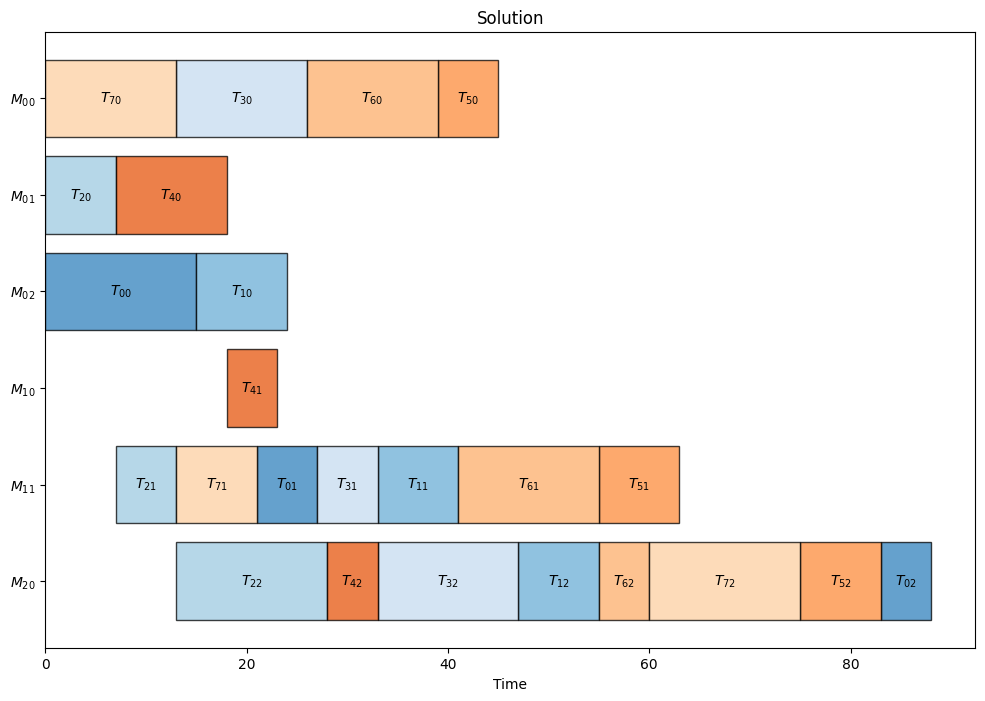

In [9]:
from pyjobshop.plot import plot_machine_gantt

data = model.data()
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Let's visually check a few things:
- Each job is scheduled in each stage exactly once.
- For each job, tasks on consecutive machines maintain proper sequencing (one completes before the next begins).

Great! Let's look at a more complex version of HFS next.

## Transportation restrictions

In some manufacturing environments, there may be physical restrictions between machines that allow tasks only to be scheduled between machines that are connected to each other. For example, consider this enviroment:

```
Stage 0        Stage 1        Stage 2
┌─────┐        ┌─────┐        ┌─────┐
│ M00 │───────▶│ M10 │───┬───▶│ M20 │
└─────┘        └─────┘   │    └─────┘
                         │
┌─────┐        ┌─────┐   │
│ M01 │───┬───▶│ M11 │───┘
└─────┘   │    └─────┘
          │
┌─────┐   │
│ M02 │───┘
└─────┘
```
The HFS in this case only allows jobs that are scheduled on $M_{00}$, to be consecutively processed on $M_{10}$ and not $M_{11}$. Similarliy, jobs that are scheduled on $M_{01}$ or $M_{02}$ can only be processed on $M_{11}$ afterwards.

Let's start by copying the previous HFS example, where we additionally store the modes of each task.

In [13]:
model = Model()

machines = [
    [model.add_machine(name=machine_name(k, m)) for m in range(num)]
    for k, num in enumerate(num_machines)
]
jobs = [model.add_job() for _ in range(num_jobs)]
tasks = {}

for j, job in enumerate(jobs):
    for k in range(num_stages):
        task = model.add_task(job, name=task_name(j, k))
        tasks[j, k] = task

    for k in range(num_stages):
        for machine in machines[k]:
            task = tasks[j, k]
            duration = PROCESSING_TIMES[j, k]
            model.add_mode(task, machine, duration)

    for k in range(num_stages - 1):
        first = tasks[j, k]
        second = tasks[j, k + 1]
        model.add_end_before_start(first, second)

To model transportation restrictions, we have to take a look at how we've defined the problem. Every job is split into multiple tasks, one for each stage. Each task has a set of modes, which represent the possible machine allocations. If we want to restrict the movement of a job, then we need to restrict which modes can be selected, depending on which of the previous modes were selected.

To model such dependencies, we can use the `ModeDependency` constraint. The mode dependency constraint works as follows: if a given mode is selected, then at least one mode out of a set of other modes must be selected.

The way we can use this constraint is by stating that if a mode is selected (a task and machine pair) then we must select another mode (the next task with a feasible machine).

The following is mostly a "data structure" problem. We have to find the modes that belong to the same job, and then constrain which modes are dependent on each other. While we could have designed a more convenient data structure right at the start, this will also show how objects such as tasks and modes are internally represented in PyJobShop.

TODO: 
- organize modes by job ?
- then add mode dependencies

In [66]:
job2modes = [[] for _ in range(num_jobs)]

for mode in model.modes:
    job = model.tasks[mode.task].job
    job2modes[job].append(mode)

Instead of using the machine index pairs, it's easier to use their actual resource index that PyJobShop uses internally:

In [24]:
for idx, resource in enumerate(model.resources):
    print(idx, resource.name)

0 $M_{00}$
1 $M_{01}$
2 $M_{02}$
3 $M_{10}$
4 $M_{11}$
5 $M_{20}$


In [67]:
allowed = {0: 3, 1: 4, 2: 4}

In [69]:
for idx, modes1 in enumerate(job2modes):
    modes2 = job2modes[idx]

    for mode1 in modes1:
        for mode2 in modes2:
            machine1 = mode1.resources[0]
            machine2 = mode2.resources[0]

            if allowed.get(machine1) == machine2:
                model.add_mode_dependency(mode1, [mode2])

In [71]:
result = model.solve(display=False)
print(result)

Solution results
  objective: 88.00
lower bound: 88.00
     status: Optimal
    runtime: 0.01 seconds


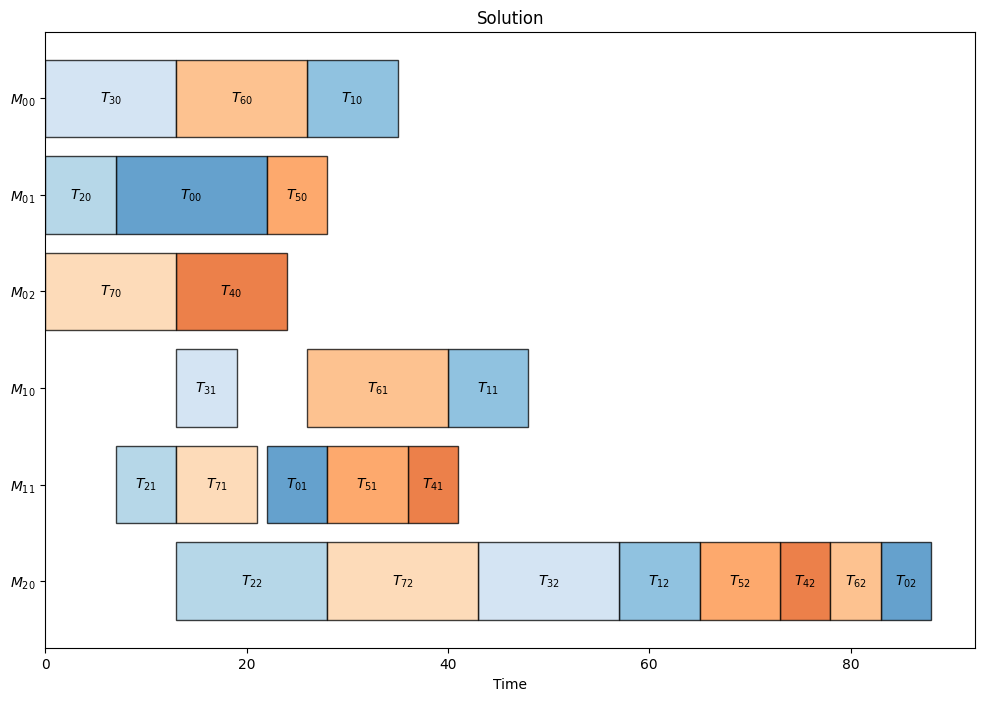

In [72]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

We can verify that tasks follow the transportation restrictions: 
- Jobs with tasks scheduled on machine $M_{00}$ must be processed next on machine $M_{10}$.
- Jobs with tasks scheduled on machine $M_{01}$ and $M_{02}$ are processed next on machine $M_{11}$.

## Conclusion
This notebook demonstrated how to model and solve hybrid flow shop problems using PyJobShop. We showed how to model:

1. **Classic HFS**: Define tasks, modes, and precedence constraints to create a standard hybrid flow shop
2. **HFS with transportation restrictions**: Use mode dependencies to restrict which machines can be used in sequence, modeling physical transportation restrictions in manufacturing environments

The hybrid flow shop is a flexible scheduling environment that captures many real-world manufacturing scenarios where jobs must flow through stages with parallel machines.

